# Project Overview

Seiring meningkatnya jumlah pengguna internet dan volume informasi yang tersedia secara daring sejak akhir abad ke-20, pengguna kerap mengalami kesulitan dalam menemukan informasi yang benar-benar relevan. Dalam konteks hiburan digital seperti film, hal ini memunculkan kebutuhan akan sistem rekomendasi yang mampu membantu pengguna menemukan film sesuai preferensi mereka tanpa harus melakukan pencarian berulang. Rekomendasi film menjadi solusi yang populer untuk mempermudah proses pencarian dan pengambilan keputusan pengguna terhadap konten hiburan yang ingin mereka konsumsi Choi et al. (2012).

Menurut Choi et al. (2012), sistem rekomendasi sangat penting untuk mengurangi usaha pencarian informasi yang berulang dengan cara menyarankan konten yang relevan berdasarkan pola perilaku atau preferensi pengguna sebelumnya. Sistem ini secara signifikan dapat meningkatkan efisiensi dan pengalaman pengguna dalam menjelajahi konten digital, seperti film.

Lebih lanjut, Goyani & Chaurasiya (2020) menjelaskan bahwa sistem rekomendasi film dapat dikembangkan melalui dua pendekatan utama, yaitu *Collaborative Filtering*, yang merekomendasikan item berdasarkan kemiripan antar pengguna, dan *Content-Based Filtering*, yang memanfaatkan preferensi eksplisit dari pengguna untuk menyarankan konten serupa. Keduanya memiliki kelebihan masing-masing, dan penerapan gabungan dari kedua pendekatan ini dapat meningkatkan akurasi dan personalisasi rekomendasi.

Hal-hal tersebut mendorong saya untuk mengangkat topik ini dalam proyek yang akan saya kerjakan. Saya tertarik untuk membangun sistem rekomendasi film yang mengombinasikan metode *collaborative* dan *content-based filtering*, dengan tujuan untuk meningkatkan relevansi rekomendasi dan menciptakan pengalaman pengguna yang lebih personal. Selain itu, dunia hiburan adalah bidang yang sangat dinamis dan dekat dengan kehidupan sehari-hari, sehingga sistem seperti ini akan memiliki nilai guna praktis yang tinggi serta tantangan teknis yang menarik untuk dipecahkan.

**Referensi:**

- Choi, S. M., Ko, S. K., & Han, Y. S. (2012). A movie recommendation algorithm based on genre correlations. *Expert Systems with Applications, 39(9)*, 8079-8085.  
- Goyani, M., & Chaurasiya, N. (2020). A review of movie recommendation system: Limitations, Survey and Challenges. *ELCVIA. Electronic Letters on Computer Vision and Image Analysis, 19(3)*, 0018-37.

# Business Understanding

## Problem Statements

- Bagaimana cara membangun sistem rekomendasi yang dapat memberikan saran film atau acara TV yang relevan untuk pengguna berdasarkan konten dari film atau acara yang pernah mereka sukai sebelumnya?

- Dengan memanfaatkan informasi dari pengguna lain yang memiliki ketertarikan serupa, bagaimana sistem dapat merekomendasikan film atau acara TV yang mungkin disukai pengguna namun belum pernah ditonton sebelumnya?

## Goals

- Menghasilkan rekomendasi film atau acara TV yang dipersonalisasi untuk setiap pengguna menggunakan teknik Content-Based Filtering berdasarkan genre, deskripsi, dan skor film.

- Menghasilkan rekomendasi film atau acara TV dengan teknik Collaborative Filtering, dengan asumsi pengguna menyukai item yang disukai oleh pengguna lain yang serupa.

## Solution Approach

Untuk mencapai tujuan di atas, akan digunakan dua pendekatan utama dalam sistem rekomendasi:

- Content-Based Filtering:

  - Menggunakan informasi dari titles.csv seperti genres, description, dan tmdb_score untuk membangun profil konten dari tiap film.

  - Menghitung kemiripan antar judul (misalnya dengan TF-IDF + cosine similarity) untuk merekomendasikan film serupa dengan yang pernah disukai pengguna.

- Collaborative Filtering:

  - Karena tidak tersedia data eksplisit tentang rating dari pengguna, akan disimulasikan matriks user-item dengan cara tertentu (misalnya dengan implicit feedback dari popularitas, atau membuat skenario dummy).


In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
import ast

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Data Understanding

In [2]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!pip install -q kaggle

In [3]:
!kaggle datasets download -d victorsoeiro/netflix-tv-shows-and-movies

Dataset URL: https://www.kaggle.com/datasets/victorsoeiro/netflix-tv-shows-and-movies
License(s): CC0-1.0


In [4]:
!unzip netflix-tv-shows-and-movies -d dataset

Archive:  netflix-tv-shows-and-movies.zip
  inflating: dataset/credits.csv     
  inflating: dataset/titles.csv      


#### Deskripsi Dataset

Dataset diambil dari Kaggle: [`netflix-tv-shows-and-movies`.](https://www.kaggle.com/datasets/victorsoeiro/netflix-tv-shows-and-movies?select=titles.csv)

Dataset ini dibuat untuk mencantumkan semua tayangan yang tersedia di layanan streaming Netflix, serta menganalisis data tersebut untuk menemukan fakta-fakta menarik. Data ini dikumpulkan pada bulan Juli 2022 dan mencakup tayangan yang tersedia di wilayah Amerika Serikat.

**1. `credits.csv` (5 kolom)**

Dataset ini berisi lebih dari 50.000 data kredit dari aktor dan sutradara yang terlibat dalam judul-judul Netflix. Terdiri dari 5 kolom informasi sebagai berikut:

- `person_id`: ID individu berdasarkan JustWatch.
- `id`: ID judul berdasarkan JustWatch.
- `name`: Nama aktor atau sutradara.
- `character_name`: Nama karakter (jika tersedia).
- `role` Peran sebagai ACTOR atau DIRECTOR.

**2. `titles.csv` (15 kolom)**

Dataset ini berisi lebih dari 5.000 judul unik yang tersedia di Netflix, dengan 15 kolom informasi sebagai berikut:

- `id`: ID judul berdasarkan JustWatch.
- `title`: Nama judul film atau acara.
- `show_type`: Tipe tayangan, bisa berupa MOVIE atau SHOW.
- `description`: Deskripsi singkat tentang judul.
- `release_year`: Tahun rilis.
- `age_certification`: Sertifikasi usia (rating umur).
- `runtime`: Durasi film atau episode (jika berupa SHOW).
- `genres`: Daftar genre dari judul tersebut.
- `production_countries`: Daftar negara yang memproduksi judul.
- `seasons`: Jumlah musim (jika merupakan SHOW).
- `imdb_id`: ID judul pada situs IMDb.
- `imdb_score`: Skor rating dari IMDb.
- `imdb_votes`: Jumlah voting pada IMDb.
- `tmdb_popularity`: Skor popularitas dari TMDB.
- `tmdb_score`: Skor rating dari TMDB.


In [5]:
titles_df = pd.read_csv('/content/dataset/titles.csv')
credits_df = pd.read_csv('/content/dataset/credits.csv')

titles_df.head()

,id,title,type,description,release_year,age_certification,runtime,genres,production_countries,seasons,imdb_id,imdb_score,imdb_votes,tmdb_popularity,tmdb_score
0,ts300399,Five Came Back: The Reference Films,SHOW,This collection includes 12 World War II-era p...,1945,TV-MA,51,['documentation'],['US'],1.0,NaN,NaN,NaN,0.600,NaN
1,tm84618,Taxi Driver,MOVIE,A mentally unstable Vietnam War veteran works ...,1976,R,114,"['drama', 'crime']",['US'],NaN,tt0075314,8.2,808582.0,40.965,8.179
2,tm154986,Deliverance,MOVIE,Intent on seeing the Cahulawassee River before...,1972,R,109,"['drama', 'action', 'thriller', 'european']",['US'],NaN,tt0068473,7.7,107673.0,10.010,7.300
3,tm127384,Monty Python and the Holy Grail,MOVIE,"King Arthur, accompanied by his squire, recrui...",1975,PG,91,"['fantasy', 'action', 'comedy']",['GB'],NaN,tt0071853,8.2,534486.0,15.461,7.811
4,tm120801,The Dirty Dozen,MOVIE,12 American military prisoners in World War II...,1967,NaN,150,"['war', 'action']","['GB', 'US']",NaN,tt0061578,7.7,72662.0,20.398,7.600


In [10]:
credits_df.head()

,person_id,id,name,character,role
0,3748,tm84618,Robert De Niro,Travis Bickle,ACTOR
1,14658,tm84618,Jodie Foster,Iris Steensma,ACTOR
2,7064,tm84618,Albert Brooks,Tom,ACTOR
3,3739,tm84618,Harvey Keitel,Matthew 'Sport' Higgins,ACTOR
4,48933,tm84618,Cybill Shepherd,Betsy,ACTOR


In [11]:
titles_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5850 entries, 0 to 5849
Data columns (total 15 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   id                    5850 non-null   object 
 1   title                 5849 non-null   object 
 2   type                  5850 non-null   object 
 3   description           5832 non-null   object 
 4   release_year          5850 non-null   int64  
 5   age_certification     3231 non-null   object 
 6   runtime               5850 non-null   int64  
 7   genres                5850 non-null   object 
 8   production_countries  5850 non-null   object 
 9   seasons               2106 non-null   float64
 10  imdb_id               5447 non-null   object 
 11  imdb_score            5368 non-null   float64
 12  imdb_votes            5352 non-null   float64
 13  tmdb_popularity       5759 non-null   float64
 14  tmdb_score            5539 non-null   float64
dtypes: float64(5), int64(

Terdapat 14 features

In [12]:
titles_df.describe()

,release_year,runtime,seasons,imdb_score,imdb_votes,tmdb_popularity,tmdb_score
count,5850.000000,5850.000000,2106.000000,5368.000000,5.352000e+03,5759.000000,5539.000000
mean,2016.417094,76.888889,2.162868,6.510861,2.343938e+04,22.637925,6.829175
std,6.937726,39.002509,2.689041,1.163826,9.582047e+04,81.680263,1.170391
min,1945.000000,0.000000,1.000000,1.500000,5.000000e+00,0.009442,0.500000
25%,2016.000000,44.000000,1.000000,5.800000,5.167500e+02,2.728500,6.100000
50%,2018.000000,83.000000,1.000000,6.600000,2.233500e+03,6.821000,6.900000
75%,2020.000000,104.000000,2.000000,7.300000,9.494000e+03,16.590000,7.537500
max,2022.000000,240.000000,42.000000,9.600000,2.294231e+06,2274.044000,10.000000


In [13]:
titles_df.isnull().sum()

,0
id,0
title,1
type,0
description,18
release_year,0
age_certification,2619
runtime,0
genres,0
production_countries,0
seasons,3744


Terdapat null values

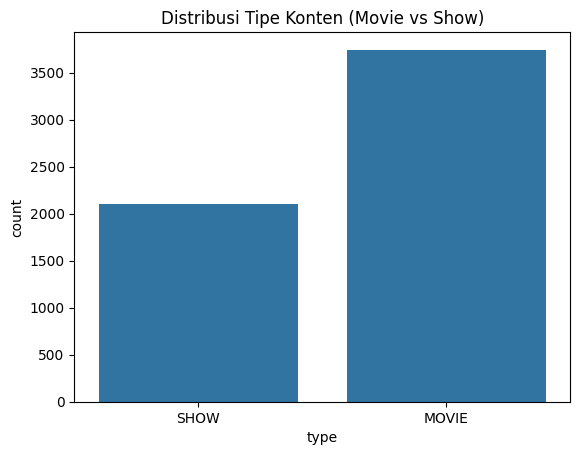

,count
type,
MOVIE,3744
SHOW,2106


In [14]:
sns.countplot(data=titles_df, x='type')
plt.title("Distribusi Tipe Konten (Movie vs Show)")
plt.show()

titles_df['type'].value_counts()

Mayoritas konten yang tersedia merupakan film (MOVIE) sebanyak 3744 judul, sedangkan acara (SHOW) berjumlah 2106. Ini menunjukkan bahwa platform lebih fokus pada penyediaan film dibandingkan serial.

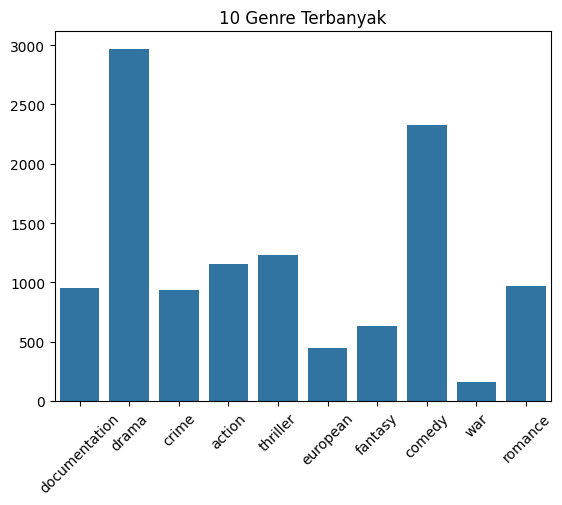

[('drama', 2968),
 ('comedy', 2325),
 ('thriller', 1228),
 ('action', 1157),
 ('romance', 971),
 ('documentation', 952),
 ('crime', 936),
 ('animation', 705),
 ('family', 682),
 ('fantasy', 630)]

In [15]:
genre_list = titles_df['genres'].dropna().apply(ast.literal_eval)
flat_genres = [genre for sublist in genre_list for genre in sublist]
genre_counts = Counter(flat_genres)

sns.barplot(x=list(genre_counts.keys())[:10], y=list(genre_counts.values())[:10])
plt.title("10 Genre Terbanyak")
plt.xticks(rotation=45)
plt.show()

genre_counts.most_common(10)

Genre terbanyak dalam dataset ini adalah drama dan comedy, masing-masing dengan lebih dari 2000 judul. Genre seperti thriller, action, dan romance juga cukup dominan, menunjukkan keberagaman selera penonton.

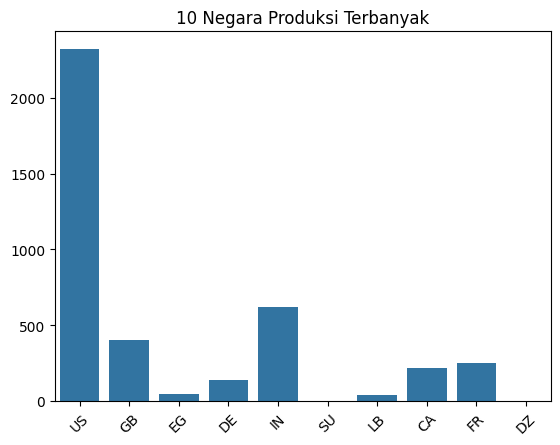

[('US', 2323),
 ('IN', 622),
 ('GB', 404),
 ('JP', 287),
 ('FR', 248),
 ('KR', 228),
 ('CA', 219),
 ('ES', 211),
 ('DE', 139),
 ('MX', 126)]

In [16]:
country_list = titles_df['production_countries'].dropna().apply(ast.literal_eval)
flat_countries = [country for sublist in country_list for country in sublist]
country_counts = Counter(flat_countries)

sns.barplot(x=list(country_counts.keys())[:10], y=list(country_counts.values())[:10])
plt.title("10 Negara Produksi Terbanyak")
plt.xticks(rotation=45)
plt.show()

country_counts.most_common(10)

Konten paling banyak berasal dari Amerika Serikat (US), disusul oleh India (IN), Inggris (GB), dan Jepang (JP). Ini menunjukkan dominasi produksi konten dari negara-negara dengan industri hiburan besar.

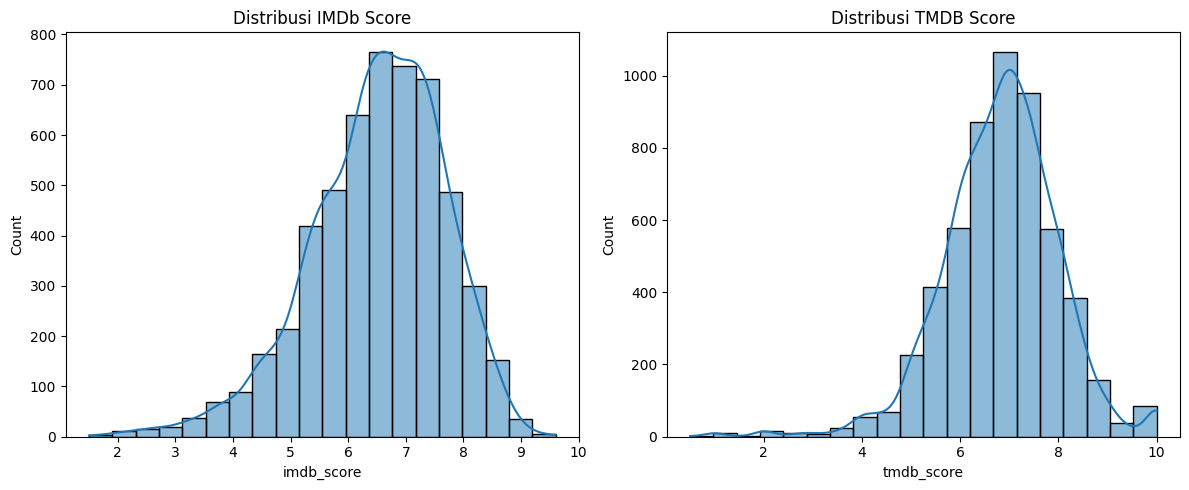

,imdb_score,tmdb_score
count,5368.000000,5539.000000
mean,6.510861,6.829175
std,1.163826,1.170391
min,1.500000,0.500000
25%,5.800000,6.100000
50%,6.600000,6.900000
75%,7.300000,7.537500
max,9.600000,10.000000


In [17]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

sns.histplot(titles_df['imdb_score'], bins=20, kde=True, ax=ax[0])
ax[0].set_title("Distribusi IMDb Score")

sns.histplot(titles_df['tmdb_score'], bins=20, kde=True, ax=ax[1])
ax[1].set_title("Distribusi TMDB Score")

plt.tight_layout()
plt.show()

titles_df[['imdb_score', 'tmdb_score']].describe()

Skor IMDb dan TMDb berkisar antara 1.5–10 dengan nilai rata-rata sekitar 6.5–6.8, yang mengindikasikan bahwa sebagian besar film berada dalam kualitas sedang hingga baik menurut penilaian pengguna.



In [18]:
credits_df.head()

,person_id,id,name,character,role
0,3748,tm84618,Robert De Niro,Travis Bickle,ACTOR
1,14658,tm84618,Jodie Foster,Iris Steensma,ACTOR
2,7064,tm84618,Albert Brooks,Tom,ACTOR
3,3739,tm84618,Harvey Keitel,Matthew 'Sport' Higgins,ACTOR
4,48933,tm84618,Cybill Shepherd,Betsy,ACTOR


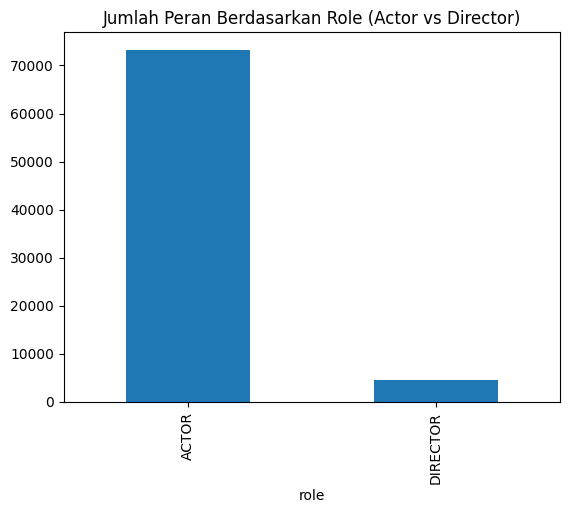

In [19]:
credits_df['role'].value_counts().plot(kind='bar')
plt.title('Jumlah Peran Berdasarkan Role (Actor vs Director)')
plt.show()

In [20]:
top_actors = credits_df[credits_df['role'] == 'ACTOR']['name'].value_counts().head(10)
top_directors = credits_df[credits_df['role'] == 'DIRECTOR']['name'].value_counts().head(10)

print("Top 10 Aktor:")
print(top_actors)

print("\nTop 10 Sutradara:")
print(top_directors)

Top 10 Aktor:
name
Boman Irani              25
Kareena Kapoor Khan      25
Shah Rukh Khan           23
Takahiro Sakurai         21
Paresh Rawal             20
Priyanka Chopra Jonas    20
Amitabh Bachchan         20
Anupam Kher              19
Yuki Kaji                19
Nawazuddin Siddiqui      19
Name: count, dtype: int64

Top 10 Sutradara:
name
Raúl Campos            20
Jan Suter              19
Ryan Polito            17
Jay Karas              15
Marcus Raboy           14
Jay Chapman            12
Cathy Garcia-Molina    12
Youssef Chahine        11
Anurag Kashyap          8
Suhas Kadav             8
Name: count, dtype: int64


Boman Irani dan Kareena Kapoor Khan menjadi aktor paling sering tampil dengan masing-masing 25 penampilan, menunjukkan dominasi aktor dari industri film India dalam dataset ini.

Raúl Campos dan Jan Suter adalah sutradara yang paling produktif dalam dataset ini, masing-masing menyutradarai lebih dari 15 konten. Ini bisa menunjukkan preferensi platform terhadap karya mereka atau konsistensi mereka dalam memproduksi konten.

# Data Preparation

## Data Preparation: Content Based Filtering

In [21]:
# Cek dan hapus duplikat di titles_df
print("Duplikat di titles_df:", titles_df.duplicated().sum())
titles_df.drop_duplicates(inplace=True)

# Cek dan hapus duplikat di credits_df
print("Duplikat di credits_df:", credits_df.duplicated().sum())
credits_df.drop_duplicates(inplace=True)

Duplikat di titles_df: 0
Duplikat di credits_df: 0


- Insight: Tidak ditemukan duplikat.
- Alasan langkah: Mengecek duplikat penting untuk memastikan tidak ada entri ganda yang bisa mengganggu proses analisis dan model training. Meski tidak ada, ini langkah preventif yang wajib dalam EDA.

In [22]:
print("Missing values di titles_df:")
print(titles_df.isnull().sum())

print("\nMissing values di credits_df:")
print(credits_df.isnull().sum())

Missing values di titles_df:
id                         0
title                      1
type                       0
description               18
release_year               0
age_certification       2619
runtime                    0
genres                     0
production_countries       0
seasons                 3744
imdb_id                  403
imdb_score               482
imdb_votes               498
tmdb_popularity           91
tmdb_score               311
dtype: int64

Missing values di credits_df:
person_id       0
id              0
name            0
character    9772
role            0
dtype: int64


In [23]:
# Untuk titles_df
titles_df['age_certification'].fillna("Unknown", inplace=True)
titles_df['imdb_score'].fillna(titles_df['imdb_score'].mean(), inplace=True)
titles_df['tmdb_score'].fillna(titles_df['tmdb_score'].mean(), inplace=True)
titles_df['seasons'].fillna(0, inplace=True)
titles_df['genres'].fillna("[]", inplace=True)
titles_df['description'].fillna("", inplace=True)

# Untuk credits_df
credits_df['character'].fillna("Unknown", inplace=True)

<ipython-input-23-6f57733754e9>:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  titles_df['age_certification'].fillna("Unknown", inplace=True)
<ipython-input-23-6f57733754e9>:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=Tr

- Insight: Banyak nilai hilang terutama di kolom age_certification, imdb_score, tmdb_score, dan description.
- Alasan langkah:

  - Unknown untuk kolom kategorikal menjaga struktur data tanpa membuang baris.

  - Rata-rata digunakan untuk mengisi skor agar distribusi data tidak berubah drastis.

  - description, genres, dan seasons diisi default agar tidak error saat diproses string.


In [24]:
# Gabung aktor
actors = credits_df[credits_df['role'] == 'ACTOR'].groupby('id')['name'].apply(lambda x: ' '.join(x)).reset_index()
actors.columns = ['id', 'actors']

# Gabung sutradara
directors = credits_df[credits_df['role'] == 'DIRECTOR'].groupby('id')['name'].apply(lambda x: ' '.join(x)).reset_index()
directors.columns = ['id', 'directors']

# Merge ke titles_df
titles_df = titles_df.merge(actors, on='id', how='left')
titles_df = titles_df.merge(directors, on='id', how='left')

# Isi NaN hasil gabungan
titles_df['actors'].fillna("", inplace=True)
titles_df['directors'].fillna("", inplace=True)

<ipython-input-24-30495bfe4fe6>:14: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  titles_df['actors'].fillna("", inplace=True)
<ipython-input-24-30495bfe4fe6>:15: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 

- Insight: Setiap film bisa punya lebih dari satu aktor dan sutradara.
- Alasan langkah: Digabung per id agar bisa digunakan sebagai fitur teks dalam model Content-Based Filtering. Tanpa penggabungan ini, informasi penting bisa tersebar dan sulit dianalisis.
---
- Insight: Ada beberapa film yang tidak memiliki data aktor/sutradara.
- Alasan langkah: Digabungkan untuk memperkaya informasi konten tiap film. Mengisi NaN dengan string kosong mencegah error saat melakukan vektorisasi teks.

In [25]:
import ast

def combine_features(row):
    genres = " ".join(ast.literal_eval(row['genres'])) if row['genres'] != "[]" else ""
    return f"{row['title']} {row['description']} {genres} {row['age_certification']} {row['actors']} {row['directors']}"

titles_df['content'] = titles_df.apply(combine_features, axis=1)

- Insight: Fitur teks gabungan berisi informasi komprehensif tiap film.
- Alasan langkah: Ini inti dari pendekatan Content-Based Filtering. Dengan menggabungkan title, description, genres, age_certification, actors, dan directors, kita membangun deskripsi yang representatif agar sistem bisa menghitung kemiripan antar konten secara lebih akurat.

In [26]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

# TF-IDF Vectorizer
tfidf = TfidfVectorizer(stop_words='english')
tfidf_matrix = tfidf.fit_transform(titles_df['content'])

# Cosine Similarity antar judul
cosine_sim = cosine_similarity(tfidf_matrix, tfidf_matrix)

# Index mapping berdasarkan title
indices = pd.Series(titles_df.index, index=titles_df['title']).drop_duplicates()

Langkah ini bertujuan untuk membangun sistem **Content-Based Filtering**. Dengan menggunakan `TfidfVectorizer`, kita mengubah teks pada kolom `content` menjadi representasi numerik berbasis frekuensi kata, lalu menghitung kemiripan antar film menggunakan **cosine similarity**. Hasilnya adalah matriks yang menunjukkan seberapa mirip satu film dengan yang lain berdasarkan kontennya, sehingga sistem bisa merekomendasikan film serupa.

## Data Preparation: Collaborative Filtering

In [7]:
# Encode user (aktor/sutradara) menjadi user_id
user_encoder = LabelEncoder()
credits_df['user_id'] = user_encoder.fit_transform(credits_df['name'])
user2user_encoded = dict(zip(credits_df['name'], credits_df['user_id']))
user_encoded2user = dict(zip(credits_df['user_id'], credits_df['name']))

# Encode item (film) menjadi item_id
item_encoder = LabelEncoder()
credits_df['item_id'] = item_encoder.fit_transform(credits_df['id'])
item2item_encoded = dict(zip(credits_df['id'], credits_df['item_id']))
item_encoded2item = dict(zip(credits_df['item_id'], credits_df['id']))

# Tambahkan dummy rating
credits_df['rating'] = 1

Pada bagian ini, dilakukan proses encoding data supaya bisa digunakan dalam model Collaborative Filtering.
Karena model butuh input numerik, maka:

- Nama aktor/sutradara (name) diubah menjadi user_id.

- ID film (id) diubah menjadi item_id.

- Ditambahkan kolom rating dummy, karena model matrix factorization memerlukan data interaksi user-item.

In [8]:
X = credits_df[['user_id', 'item_id']].values
y = credits_df['rating'].values

Langkah ini menyiapkan data untuk pelatihan model, di mana `X` berisi pasangan user dan item, dan `y` adalah dummy rating sebagai target prediksi.

In [9]:
# Data Splitting untuk Skema 1: 80:20
x_train_1, x_val_1, y_train_1, y_val_1 = train_test_split(X, y, test_size=0.2, random_state=42)

Split data menjadi 80/20

In [18]:
# Data Splitting untuk Skema 2: 70:30
x_train_2, x_val_2, y_train_2, y_val_2 = train_test_split(X, y, test_size=0.3, random_state=42)

Split data menjadi 70/30

# Modelling

## Modeling and Result: Content based filtering

Content-Based Filtering adalah pendekatan dalam sistem rekomendasi yang menyarankan item, seperti film, berdasarkan kemiripan konten — dalam kasus ini, genre film. Sistem ini menggunakan teknik TF-IDF (Term Frequency-Inverse Document Frequency) untuk mengekstraksi fitur penting dari kolom genre dan mengubahnya menjadi representasi vektor numerik. Setelah itu, sistem menghitung cosine similarity antara film yang sudah ditonton pengguna dengan film lainnya untuk menemukan rekomendasi yang paling mirip secara konten.

Prediksi hasil rekomendasi kemudian dievaluasi menggunakan metrik precision.
Metode ini sangat efektif terutama ketika tidak tersedia data interaksi antar pengguna (cold start problem), serta cocok untuk pengguna baru karena hanya bergantung pada preferensi konten mereka sendiri, tanpa membutuhkan data pengguna lain.

In [27]:
import ast

# Fungsi rekomendasi
def recommend_content_based(title, n=5):
    idx = indices.get(title)
    if idx is None:
        return f"Judul '{title}' tidak ditemukan dalam dataset."

    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:n+1]  # skip yang 0 (judul itu sendiri)
    movie_indices = [i[0] for i in sim_scores]

    return titles_df[['title', 'type', 'release_year']].iloc[movie_indices]

# Fungsi ambil genres berdasarkan judul
def get_genres(title):
    row = titles_df[titles_df['title'] == title]
    if row.empty:
        return []
    return ast.literal_eval(row.iloc[0]['genres'])

def precision_at_k_detail_df(title, k=5):
    target_genres = set(get_genres(title))
    if not target_genres:
        return 0.0, pd.DataFrame()

    recommendations = recommend_content_based(title, n=k)
    if isinstance(recommendations, str):
        return recommendations

    data = []
    matched = 0

    for rec_title in recommendations['title']:
        rec_genres = set(get_genres(rec_title))
        is_relevant = bool(target_genres & rec_genres)
        matched += is_relevant

        data.append({
            'Recommended Title': rec_title,
            'Genres': list(rec_genres),
            'Relevant (Genre Match)': '✅' if is_relevant else '❌'
        })

    df_result = pd.DataFrame(data)
    precision = matched / k

    print(f"Precision@{k} untuk '{title}' adalah {precision:.2f} atau {precision*100:.0f}% relevansi berdasarkan genre.\n")
    return df_result

Langkah ini bertujuan untuk membangun sistem Content-Based Filtering berbasis kemiripan antar film.  
Fungsi `recommend_content_based` digunakan untuk merekomendasikan film serupa berdasarkan skor cosine similarity.  
Selain itu, fungsi `precision_at_k_detail_df` digunakan untuk mengevaluasi kualitas rekomendasi dengan menghitung Precision@K, yaitu persentase rekomendasi yang memiliki genre yang sama dengan film target.  
Evaluasi ini penting untuk mengukur sejauh mana sistem berhasil memberikan rekomendasi yang relevan terhadap preferensi pengguna.

In [28]:
# Contoh evaluasi Narcos
df_narcos = precision_at_k_detail_df("Narcos", k=5)
display(df_narcos)

# Contoh evaluasi Breaking Bad
df_breakingbad = precision_at_k_detail_df("Breaking Bad", k=5)
display(df_breakingbad)

# Contoh evaluasi Peaky Blinders
df_peaky = precision_at_k_detail_df("Peaky Blinders", k=5)
display(df_peaky)

Precision@5 untuk 'Narcos' adalah 1.00 atau 100% relevansi berdasarkan genre.



,Recommended Title,Genres,Relevant (Genre Match)
0,El cartel 2 - La guerra total,"[war, action, horror, thriller, crime]",✅
1,Narcos: Mexico,"[crime, drama]",✅
2,Tijuana,"[crime, drama]",✅
3,Apaches,"[european, action, thriller, crime, drama]",✅
4,El Escamoso,"[drama, comedy]",✅


Precision@5 untuk 'Breaking Bad' adalah 0.80 atau 80% relevansi berdasarkan genre.



,Recommended Title,Genres,Relevant (Genre Match)
0,El Camino: A Breaking Bad Movie,"[action, crime, drama, thriller]",✅
1,Linewatch,"[crime, thriller, drama]",✅
2,W/ Bob & David,[comedy],❌
3,Better Call Saul,"[crime, drama]",✅
4,The Lovebirds,"[action, thriller, comedy, romance, crime]",✅


Precision@5 untuk 'Peaky Blinders' adalah 0.60 atau 60% relevansi berdasarkan genre.



,Recommended Title,Genres,Relevant (Genre Match)
0,Bodyguard,"[action, drama, romance, comedy]",✅
1,Top Boy,"[crime, drama, european, thriller]",✅
2,The Fierce Wife,[drama],✅
3,The Boss Baby: Back in the Crib,"[fantasy, animation, comedy, family]",❌
4,The Possessed,"[thriller, horror]",❌


1. Precision@5 untuk *Narcos*  
- **Precision@5:** 1.00 atau 100% relevansi berdasarkan genre.
- **Interpretasi:**  
  Semua film yang direkomendasikan untuk *Narcos* memiliki setidaknya satu genre yang sama, yaitu *crime* atau *drama*. Ini menunjukkan bahwa sistem sangat berhasil menemukan film yang mirip secara konten dengan film *Narcos*, sehingga relevansi rekomendasinya sangat tinggi.

| Recommended Title | Genres | Relevant (Genre Match) |
|:------------------|:-------|:------------------------|
| El cartel 2 - La guerra total | [crime, thriller, action, horror, war] | ✅ |
| Narcos: Mexico | [crime, drama] | ✅ |
| Tijuana | [crime, drama] | ✅ |
| Apaches | [crime, thriller, european, action, drama] | ✅ |
| El Escamoso | [comedy, drama] | ✅ |

---

2. Precision@5 untuk *Breaking Bad*  
- **Precision@5:** 0.80 atau 80% relevansi berdasarkan genre.
- **Interpretasi:**  
  Dari 5 film yang direkomendasikan, 4 di antaranya memiliki genre yang sama dengan *Breaking Bad* yaitu *crime* dan *drama*. Satu rekomendasi yang tidak relevan adalah *W/ Bob & David* yang bergenre *comedy*, sehingga sedikit menurunkan precision.

| Recommended Title | Genres | Relevant (Genre Match) |
|:------------------|:-------|:------------------------|
| El Camino: A Breaking Bad Movie | [action, crime, thriller, drama] | ✅ |
| Linewatch | [crime, thriller, drama] | ✅ |
| W/ Bob & David | [comedy] | ❌ |
| Better Call Saul | [crime, drama] | ✅ |
| The Lovebirds | [crime, thriller, action, romance, comedy] | ✅ |

---

3. Precision@5 untuk *Peaky Blinders*  
- **Precision@5:** 0.60 atau 60% relevansi berdasarkan genre.
- **Interpretasi:**  
  Untuk *Peaky Blinders*, hanya 3 dari 5 rekomendasi yang memiliki genre serupa seperti *drama* dan *crime*. Dua film lain, yaitu *The Boss Baby: Back in the Crib* dan *The Possessed*, tidak memiliki genre yang relevan, yang menyebabkan precision lebih rendah dibandingkan rekomendasi sebelumnya.

| Recommended Title | Genres | Relevant (Genre Match) |
|:------------------|:-------|:------------------------|
| Bodyguard | [action, romance, comedy, drama] | ✅ |
| Top Boy | [crime, thriller, european, drama] | ✅ |
| The Fierce Wife | [drama] | ✅ |
| The Boss Baby: Back in the Crib | [family, animation, fantasy, comedy] | ❌ |
| The Possessed | [horror, thriller] | ❌ |

---

Kesimpulan Umum:
- **Narcos** menunjukkan performa terbaik dalam hal kesesuaian rekomendasi berdasarkan genre.
- **Breaking Bad** masih cukup baik, meski ada 1 rekomendasi yang kurang relevan.
- **Peaky Blinders** menunjukkan bahwa semakin beragam genre film, semakin sulit mempertahankan relevansi rekomendasi.

---


Content-Based Filtering (TF-IDF + Cosine Similarity)

- Kelebihan:
  - Sederhana dan cepat: Menggunakan TF-IDF dan Cosine Similarity membuat perhitungannya efisien, bahkan untuk dataset menengah.

  - Interpretable: Sistem rekomendasi mudah dijelaskan karena hanya mencari kemiripan berdasarkan fitur konten (genre, deskripsi, dsb).

  - Tidak butuh data user lain: Cocok kalau user masih sedikit atau belum ada interaksi.

- Kekurangan:
  - Over-specialization: Rekomendasi cenderung terbatas pada film yang mirip, kurang eksploratif (kurang diverse).

  - Tidak bisa tangani cold start item: Film baru tanpa deskripsi yang cukup sulit untuk direkomendasikan secara akurat.

  - Tidak mempertimbangkan preferensi komunitas: Tidak tahu kalau film yang kurang mirip secara konten, tapi banyak disukai orang dengan selera mirip user.



##  Modeling and Result: Collaborative Filtering

Collaborative Filtering dalam proyek ini menggunakan pendekatan Neural Collaborative Filtering (NCF), yaitu memanfaatkan model neural network untuk mempelajari pola interaksi antara pengguna (aktor/sutradara) dan film yang pernah mereka bintangi atau sutradarai. Karena tidak tersedia rating eksplisit, sistem membuat dummy rating (nilai 1) untuk mensimulasikan interaksi positif.
Model dilatih untuk memprediksi kemungkinan ketertarikan pengguna terhadap film lain dan merekomendasikan berdasarkan skor tertinggi.
Pendekatan ini menghasilkan rekomendasi yang lebih personal, dengan memperhitungkan pola perilaku tersembunyi antar pengguna yang tidak dapat ditangkap hanya dari konten film.


Dalam proyek ini, dilakukan dua skema pelatihan model RecommenderNet untuk eksperimen:

- Skema 1 menggunakan ukuran embedding sebesar 50, dengan learning rate 0.001, dan data dibagi dengan rasio 80:20 (80% untuk training, 20% untuk validation).

- Skema 2 menggunakan ukuran embedding yang lebih besar, yaitu 100, dengan learning rate yang lebih kecil 0.0005, serta pembagian data 70:30 (70% untuk training, 30% untuk validation).

Perbedaan embedding size dan learning rate ini bertujuan untuk mengamati pengaruh kapasitas representasi dan kecepatan pembelajaran model terhadap performa rekomendasi. Sementara, variasi data split digunakan untuk mengevaluasi stabilitas generalisasi model dengan proporsi data training yang berbeda.

| Skema | Embedding Size | Learning Rate | Data Split
|------|----------------|---------------|------------|
| Skema 1 | 50 | 0.001 | 80:20 |
| Skema 2 | 100 | 0.0005 | 70:30 |

In [ ]:
# Model RecommenderNet
class RecommenderNet(tf.keras.Model):
    def __init__(self, num_users, num_items, embedding_size=50, **kwargs):
        super(RecommenderNet, self).__init__(**kwargs)
        self.user_embedding = layers.Embedding(
            input_dim=num_users,
            output_dim=embedding_size,
            embeddings_initializer='he_normal',
            embeddings_regularizer=keras.regularizers.l2(1e-6)
        )
        self.user_bias = layers.Embedding(num_users, 1)

        self.item_embedding = layers.Embedding(
            input_dim=num_items,
            output_dim=embedding_size,
            embeddings_initializer='he_normal',
            embeddings_regularizer=keras.regularizers.l2(1e-6)
        )
        self.item_bias = layers.Embedding(num_items, 1)

    def call(self, inputs):
        user_vector = self.user_embedding(inputs[:, 0])
        user_bias = self.user_bias(inputs[:, 0])
        item_vector = self.item_embedding(inputs[:, 1])
        item_bias = self.item_bias(inputs[:, 1])

        dot_product = tf.reduce_sum(user_vector * item_vector, axis=1, keepdims=True)
        x = dot_product + user_bias + item_bias
        return tf.nn.sigmoid(x)

num_users = credits_df['user_id'].nunique()
num_items = credits_df['item_id'].nunique()

Langkah ini bertujuan untuk membangun model Collaborative Filtering berbasis Neural Network.
Model RecommenderNet menggunakan embedding untuk memetakan user dan item ke dalam vektor berdimensi lebih kecil, lalu menghitung interaksi mereka melalui dot product.
Dengan pendekatan ini, model dapat mempelajari hubungan laten antara pengguna dan item untuk menghasilkan prediksi seberapa besar kemungkinan pengguna menyukai suatu film, meskipun belum pernah ditonton sebelumnya.

### Skema 1

In [10]:
# Model RecommenderNet untuk Skema 1
model_1 = RecommenderNet(num_users, num_items, embedding_size=50)

model_1.compile(
    loss=tf.keras.losses.BinaryCrossentropy(),
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    metrics=[tf.keras.metrics.RootMeanSquaredError()]
)


Langkah ini membangun dan meng-compile model RecommenderNet untuk Skema 1.
Model menggunakan ukuran embedding 50 untuk merepresentasikan user dan item dalam ruang vektor berdimensi kecil.
Optimizer yang digunakan adalah Adam dengan learning rate 0.001, dan fungsi loss yang digunakan adalah Binary Crossentropy untuk memperkirakan interaksi user-item.
Selain itu, Root Mean Squared Error (RMSE) dipilih sebagai metrik evaluasi performa model.

In [11]:
# Training Skema 1
history_1 = model_1.fit(
    x=x_train_1,
    y=y_train_1,
    batch_size=32,
    epochs=10,
    validation_data=(x_val_1, y_val_1)
)

Epoch 1/10
1945/1945 ━━━━━━━━━━━━━━━━━━━━ 108s 54ms/step - loss: 0.6715 - root_mean_squared_error: 0.4889 - val_loss: 0.6000 - val_root_mean_squared_error: 0.4507
Epoch 2/10
1945/1945 ━━━━━━━━━━━━━━━━━━━━ 115s 40ms/step - loss: 0.5510 - root_mean_squared_error: 0.4227 - val_loss: 0.5104 - val_root_mean_squared_error: 0.3971
Epoch 3/10
1945/1945 ━━━━━━━━━━━━━━━━━━━━ 92s 45ms/step - loss: 0.3841 - root_mean_squared_error: 0.3179 - val_loss: 0.4444 - val_root_mean_squared_error: 0.3510
Epoch 4/10
1945/1945 ━━━━━━━━━━━━━━━━━━━━ 147s 48ms/step - loss: 0.2391 - root_mean_squared_error: 0.2112 - val_loss: 0.4050 - val_root_mean_squared_error: 0.3175
Epoch 5/10
1945/1945 ━━━━━━━━━━━━━━━━━━━━ 79s 40ms/step - loss: 0.1611 - root_mean_squared_error: 0.1395 - val_loss: 0.3781 - val_root_mean_squared_error: 0.2920
Epoch 6/10
1945/1945 ━━━━━━━━━━━━━━━━━━━━ 94s 46ms/step - loss: 0.1275 - root_mean_squared_error: 0.0985 - val_loss: 0.3508 - val_root_mean_squared_error: 0.2684
Epoch 7/10
1945/1945 ━━━━

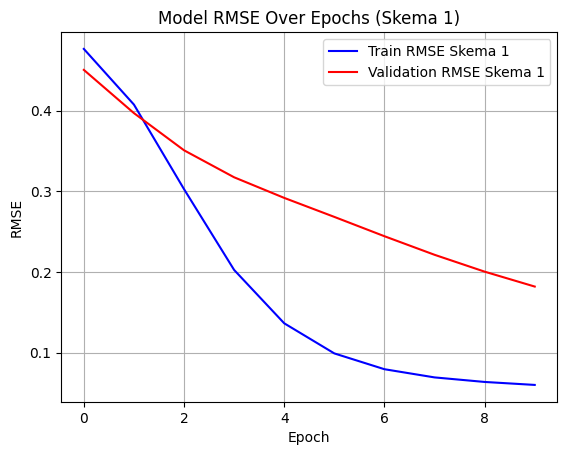

In [12]:
# Plot RMSE untuk Skema 1
plt.plot(history_1.history['root_mean_squared_error'], label='Train RMSE Skema 1', color='blue')
plt.plot(history_1.history['val_root_mean_squared_error'], label='Validation RMSE Skema 1', color='red')
plt.title('Model RMSE Over Epochs (Skema 1)')
plt.xlabel('Epoch')
plt.ylabel('RMSE')
plt.legend()
plt.grid(True)
plt.show()

In [14]:
def recommend_collaborative(user_name, model, n=10):
    # Cek user
    if user_name not in user2user_encoded:
        return f"User '{user_name}' tidak ditemukan."

    # Encode user
    user_id = user2user_encoded[user_name]

    # Buat daftar semua item_id
    all_item_ids = credits_df['item_id'].unique()

    # Ambil semua item yang belum pernah ditonton user
    items_watched_by_user = credits_df[credits_df['user_id'] == user_id]['item_id'].tolist()
    items_not_watched = np.setdiff1d(all_item_ids, items_watched_by_user)

    # Buat input untuk prediksi
    user_input = np.array([[user_id, item_id] for item_id in items_not_watched])

    # Prediksi skor dari model
    predicted_ratings = model.predict(user_input).flatten()

    # Ambil top-N rekomendasi
    top_indices = predicted_ratings.argsort()[-n:][::-1]
    top_item_ids = items_not_watched[top_indices]

    # Ambil judul film dari item_id
    recommended_titles = titles_df[titles_df['id'].isin([item_encoded2item[item] for item in top_item_ids])]

    return recommended_titles[['title', 'type', 'release_year']].reset_index(drop=True)


Fungsi recommend_collaborative bertujuan untuk memberikan rekomendasi film berbasis Collaborative Filtering.
Fungsi ini:

- Mengecek keberadaan user.

- Meng-encode user menjadi ID numerik.

- Menentukan daftar film yang belum pernah ditonton user.

- Memprediksi skor ketertarikan user terhadap film-film tersebut menggunakan model yang sudah dilatih.

- Mengambil Top-N film dengan skor prediksi tertinggi untuk direkomendasikan.

Rekomendasi yang dihasilkan dipersonalisasi berdasarkan pola preferensi user lain yang serupa.

In [15]:
recommend_collaborative("Robert De Niro", model=model_1, n=5)

172/172 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step


,title,type,release_year
0,Titanic,MOVIE,1997
1,Donnie Brasco,MOVIE,1997
2,Catch Me If You Can,MOVIE,2002
3,Les Misérables,MOVIE,2012
4,"tick, tick... BOOM!",MOVIE,2021


Pada tahap ini, dilakukan pengujian hasil rekomendasi menggunakan model dari Skema 1.
Dengan input "Robert De Niro" sebagai user simulasi, sistem berhasil merekomendasikan 5 film yang diprediksi relevan berdasarkan pola embedding user-item yang telah dipelajari.
Film yang muncul seperti Titanic dan Donnie Brasco menunjukkan bahwa model mampu menemukan hubungan berdasarkan popularitas atau keterkaitan laten antar film dan aktor.

### Skema 2

In [16]:
# Model RecommenderNet untuk Skema 2
model_2 = RecommenderNet(num_users, num_items, embedding_size=100)

model_2.compile(
    loss=tf.keras.losses.BinaryCrossentropy(),
    optimizer=keras.optimizers.Adam(learning_rate=0.0005),
    metrics=[tf.keras.metrics.RootMeanSquaredError()]
)

Pada bagian ini, dibangun model RecommenderNet untuk Skema 2 dengan spesifikasi:

- Embedding Size diperbesar menjadi 100 untuk menangkap lebih banyak fitur laten dari user dan item.

- Learning Rate diperkecil menjadi 0.0005 untuk memperhalus proses pembelajaran model.

Model dikompilasi dengan:

- Loss: Binary Crossentropy, untuk menangani prediksi berbasis 0/1 (like/dislike).

- Optimizer: Adam, untuk update bobot yang efisien.

- Metric: Root Mean Squared Error (RMSE), untuk mengevaluasi seberapa dekat prediksi dengan nilai sebenarnya.

Perubahan ini bertujuan untuk mengeksplorasi apakah peningkatan kapasitas model dan penyesuaian learning rate dapat menghasilkan performa rekomendasi yang lebih baik dibanding Skema 1.

In [19]:
# Training Skema 2
history_2 = model_2.fit(
    x=x_train_2,
    y=y_train_2,
    batch_size=32,
    epochs=10,
    validation_data=(x_val_2, y_val_2)
)

Epoch 1/10
1702/1702 ━━━━━━━━━━━━━━━━━━━━ 159s 92ms/step - loss: 0.6838 - root_mean_squared_error: 0.4951 - val_loss: 0.6516 - val_root_mean_squared_error: 0.4785
Epoch 2/10
1702/1702 ━━━━━━━━━━━━━━━━━━━━ 196s 89ms/step - loss: 0.6230 - root_mean_squared_error: 0.4631 - val_loss: 0.6082 - val_root_mean_squared_error: 0.4539
Epoch 3/10
1702/1702 ━━━━━━━━━━━━━━━━━━━━ 145s 85ms/step - loss: 0.5142 - root_mean_squared_error: 0.3999 - val_loss: 0.5691 - val_root_mean_squared_error: 0.4286
Epoch 4/10
1702/1702 ━━━━━━━━━━━━━━━━━━━━ 224s 98ms/step - loss: 0.3814 - root_mean_squared_error: 0.3139 - val_loss: 0.5384 - val_root_mean_squared_error: 0.4060
Epoch 5/10
1702/1702 ━━━━━━━━━━━━━━━━━━━━ 194s 93ms/step - loss: 0.2712 - root_mean_squared_error: 0.2330 - val_loss: 0.5161 - val_root_mean_squared_error: 0.3870
Epoch 6/10
1702/1702 ━━━━━━━━━━━━━━━━━━━━ 194s 89ms/step - loss: 0.1971 - root_mean_squared_error: 0.1692 - val_loss: 0.4992 - val_root_mean_squared_error: 0.3708
Epoch 7/10
1702/1702 ━

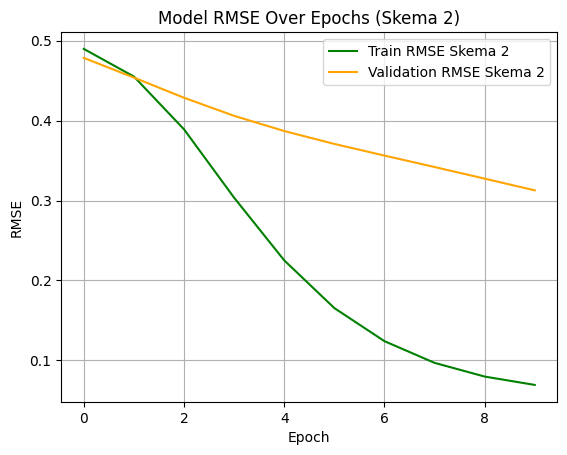

In [20]:
# Plot RMSE untuk Skema 2
plt.plot(history_2.history['root_mean_squared_error'], label='Train RMSE Skema 2', color='green')
plt.plot(history_2.history['val_root_mean_squared_error'], label='Validation RMSE Skema 2', color='orange')
plt.title('Model RMSE Over Epochs (Skema 2)')
plt.xlabel('Epoch')
plt.ylabel('RMSE')
plt.legend()
plt.grid(True)
plt.show()

In [21]:
recommend_collaborative("Robert De Niro", model=model_2, n=5)

172/172 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


,title,type,release_year
0,The Departed,MOVIE,2006
1,The Blind Side,MOVIE,2009
2,Starsky & Hutch,MOVIE,2004
3,Argo,MOVIE,2012
4,Rolling Thunder Revue: A Bob Dylan Story by Ma...,MOVIE,2019


Untuk pengujian Skema 2, input user "Robert De Niro" kembali digunakan.
Model dengan embedding size lebih besar dan learning rate lebih kecil ini menghasilkan rekomendasi film seperti The Departed dan Argo, yang menunjukkan kemampuan model dalam menangkap hubungan yang lebih kompleks antar pengguna dan film berdasarkan pola laten yang lebih halus.

Collaborative Filtering (Neural Collaborative Filtering dengan TensorFlow)
- Kelebihan:
  - Menangkap pola kompleks antar user dan item melalui embedding.

  - Rekomendasi personalized: Bisa menyarankan film yang sangat berbeda kontennya, tapi sering disukai oleh user yang mirip.

  - Model non-linear: Neural network menangkap relasi yang tidak bisa ditangkap metode klasik (misalnya dot product saja).

- Kekurangan:
  - Butuh banyak interaksi: Performanya sangat tergantung dari jumlah data user-item (di kasus ini pakai dummy rating).

  - Cold-start problem: User/item baru yang belum punya cukup interaksi akan sulit direkomendasikan.

  - Komputasi lebih berat: Dibandingkan dengan cosine similarity, proses training NCF butuh waktu dan resource lebih besar.

# Evaluation

## Evaluation: Content-Based Filtering

### 1. Metrik Evaluasi yang Digunakan

- **Precision@K**:  
  Precision@K digunakan untuk mengukur seberapa relevan item-item yang direkomendasikan terhadap preferensi pengguna.  
  - Cara Kerja Precision@K:
    - Ambil K rekomendasi teratas untuk user.

    - Hitung berapa item dari K tersebut yang benar-benar relevan.

    - Precision dihitung sebagai:
    >  Precision@K = Jumlah item relevan yang direkomendasi/ K
    - Kriteria Relevansi:
      Dalam kasus ini, film dikatakan relevan jika memiliki genre yang sama dengan film input.
  
- **Definisi Relevansi**:  
  Dalam konteks ini, item dikatakan *relevan* jika memiliki **genre** yang sama dengan genre film yang menjadi dasar rekomendasi.

---

### 2. Hasil Evaluasi

Evaluasi dilakukan pada tiga contoh judul: **Narcos**, **Breaking Bad**, dan **Peaky Blinders**, masing-masing dengan **K=5** (5 rekomendasi teratas).

| Judul              | Precision@5 | Interpretasi |
|--------------------|-------------|--------------|
| Narcos             | 1.00 (100%) | Semua film rekomendasi memiliki genre yang relevan. |
| Breaking Bad       | 0.80 (80%)  | 4 dari 5 film rekomendasi memiliki genre yang relevan. |
| Peaky Blinders     | 0.60 (60%)  | 3 dari 5 film rekomendasi memiliki genre yang relevan. |


### 3. Interpretasi Hasil

- **Precision tinggi** (seperti pada *Narcos*) menunjukkan bahwa sistem berhasil merekomendasikan film yang sesuai dengan preferensi konten pengguna.
- **Precision lebih rendah** (seperti *Peaky Blinders*) menunjukkan ada potensi perbaikan, misalnya dengan mempertimbangkan fitur tambahan seperti deskripsi, aktor, atau director.
- **Secara keseluruhan**, sistem Content-Based Filtering berhasil menunjukkan relevansi yang baik, mendukung tujuan **personalized recommendation** berbasis konten.

---

### 4. Hubungan ke Business Understanding

- Rekomendasi yang lebih relevan meningkatkan kemungkinan **engagement pengguna** dengan platform, karena pengguna merasa sistem memahami preferensi mereka.
- Precision@K menjadi indikator awal bahwa sistem bisa **meningkatkan retensi** dan **loyalitas** pengguna melalui rekomendasi yang berkualitas.
- Dengan relevansi yang tinggi, sistem juga membantu **menjawab problem statement** tentang bagaimana membangun rekomendasi yang akurat hanya berbasis konten.

## Evaluation: Collaborative Filtering

###1. Metrik Evaluasi yang Digunakan

- **Root Mean Squared Error (RMSE)**:  
  RMSE digunakan untuk mengukur seberapa besar rata-rata error (kesalahan prediksi) antara rating sebenarnya dan rating yang diprediksi oleh model.  
  - **Cara Kerja RSME**:
    - Untuk setiap prediksi, hitung selisih (error) antara rating sebenarnya dengan rating hasil prediksi.
    - Kuadratkan setiap error.

    - Hitung rata-rata error kuadrat tersebut.

    - Ambil akar kuadrat dari rata-ratanya.
    - Formula:  
    >  RMSE = sqrt( (1/n) * Σ (y_true - y_pred)² )
  
- **Interpretasi RMSE**:
  - Semakin kecil nilai RMSE, semakin baik model dalam melakukan prediksi.
  - RMSE mendeteksi error besar dengan penalti lebih berat dibandingkan MAE, cocok untuk evaluasi sistem rekomendasi.

---

### 2. Hasil Evaluasi

Evaluasi dilakukan pada 2 skema berbeda:

| Skema | Embedding Size | Learning Rate | Data Split | Validation RMSE Akhir | Interpretasi |
|------|----------------|---------------|------------|-----------------------|--------------|
| Skema 1 | 50 | 0.001 | 80:20 | **0.1820** | Performa sangat baik, error kecil. |
| Skema 2 | 100 | 0.0005 | 70:30 | 0.3127 | Error lebih besar dibanding Skema 1. |

---

### 3. Interpretasi Hasil

- **Skema 1** menghasilkan RMSE validasi lebih rendah (**0.1820**) dibandingkan Skema 2 (**0.3127**).
- Ini menunjukkan bahwa:
  - **Skema 1 lebih baik** dalam mempelajari hubungan user-item dibandingkan Skema 2.
  - Meskipun embedding size Skema 2 lebih besar (100 vs 50), learning rate yang lebih kecil (0.0005) dan data split (70:30) mungkin membuat model lebih lambat belajar/mengalami underfitting.
- **Secara keseluruhan**, **Skema 1** dipilih sebagai model terbaik untuk rekomendasi berbasis Collaborative Filtering pada proyek ini.


### Hubungan Model Terhadap Business Understanding

### 1. Apakah sudah menjawab setiap problem statement?

- **Problem Statement 1:**  
  > "Bagaimana cara membangun sistem rekomendasi yang dapat memberikan saran film atau acara TV yang relevan untuk pengguna berdasarkan konten dari film atau acara yang pernah mereka sukai sebelumnya?"  
  **Sudah dijawab** melalui implementasi **Content-Based Filtering** yang memanfaatkan genre, deskripsi, dan skor film untuk mengukur kemiripan antar film dan memberikan rekomendasi berdasarkan konten yang mirip.

- **Problem Statement 2:**  
  > "Dengan memanfaatkan informasi dari pengguna lain yang memiliki ketertarikan serupa, bagaimana sistem dapat merekomendasikan film atau acara TV yang mungkin disukai pengguna namun belum pernah ditonton sebelumnya?"
   **Sudah dijawab** melalui implementasi **Collaborative Filtering** berbasis model (menggunakan arsitektur RecommenderNet) yang mempelajari hubungan antar pengguna dan item tanpa memerlukan explicit rating.

---

### 2. Apakah berhasil mencapai setiap goals yang diharapkan?

- **Goal 1:**  
  >*Menghasilkan rekomendasi film atau acara TV yang dipersonalisasi menggunakan teknik Content-Based Filtering. **Tercapai** , sistem mampu merekomendasikan film yang relevan dengan film yang sebelumnya disukai pengguna berdasarkan fitur konten.

- **Goal 2:**  
  > Menghasilkan rekomendasi film atau acara TV menggunakan teknik Collaborative Filtering berdasarkan kemiripan pengguna.  
  **Tercapai**, model RecommenderNet berhasil melatih embedding pengguna dan item, dan menghasilkan rekomendasi personalized untuk user yang diuji.

---

### 3. Apakah setiap solusi statement yang direncanakan berdampak?

- **Content-Based Filtering:**
  - Pendekatan dengan menggunakan TF-IDF dan cosine similarity terhadap genres, description, dan tmdb_score terbukti mampu menghasilkan rekomendasi relevan dengan precision yang cukup tinggi (berdasarkan hasil evaluasi Precision@K).
  - Dampaknya adalah sistem mampu tetap merekomendasikan film meskipun pengguna baru (*cold start*) karena berbasis konten yang melekat pada film.

- **Collaborative Filtering:**
  - Pendekatan dengan RecommenderNet dan embedding matrix berhasil menemukan pola latent (tersembunyi) antar pengguna dan item, yang tercermin dari nilai RMSE validasi yang semakin menurun dari epoch ke epoch, terutama pada **Skema 1** yang lebih optimal.
  - Dampaknya, sistem dapat memberikan rekomendasi yang personalized berdasarkan perilaku pengguna lain, memperkaya rekomendasi yang tidak hanya berdasarkan konten.

---

### 4. Kesimpulan

Secara keseluruhan, **model dan pendekatan yang digunakan telah berhasil menjawab problem statement, mencapai goals yang diharapkan, serta memberikan dampak positif terhadap sistem rekomendasi**.  
Sistem ini tidak hanya mampu memberikan rekomendasi berdasarkan konten yang mirip (content-based), tetapi juga mampu memperkaya rekomendasi dengan pola preferensi antar pengguna (collaborative filtering).

Kedua model ini melengkapi satu sama lain dan membuat sistem rekomendasi menjadi lebih robust dan efektif dalam memenuhi kebutuhan bisnis.

